adcCmd# okHermEIS
Written by: Akwasi Akwaboah <br>
Date: 12/14/2022 <br>
Description:

In [1]:
import ok
import numpy as np
import matplotlib.pyplot as plt
import binascii
import struct

In [2]:
# xem = ok.FrontPanel()
# xem.OpenBySerial("")
# xem.LoadDefaultPLLConfiguration()
# xem.ConfigureFPGA('HermEIS_Top.bit')

In [3]:
#Functions
#Input Integer frequency, return 32-bit (2 16-bit [MSB, LSB])
#Frequency Control Word to fed into the Direct Digital Synthesizer
#Default clock frequency used in AD9850 is 125MHz

import numpy as np

def freq2fcw(freq_arr, dds_clk_in = 125_000_000, nbits=32): 
    nWords = int(nbits/32)
    fcw = np.zeros((len(freq_arr), nWords), dtype=np.uint32) #each word is 16 bits for okWireIn EP_DATA[15:0]
    for i in range(len(freq_arr)):
        delta_phase = np.uint64((freq_arr[i]*(2**nbits))/dds_clk_in) #used 64 to make function generic
        for j in range(nWords):
            # LSW #Little Endian --> LSW to smaller index
            # int is equivalent to remainder after modulus 2**16 
            fcw[i,j] =  (delta_phase%(2**((j+1)*32)))/(2**(j*32))
    return fcw

def setMSB_LSB(MSB, LSB, shiftBits):
    Word = (MSB << shiftBits) + LSB
    return Word

def genAdaptiveFs(fi,fs):
    if (fi <= fs//4):
        if (fs//fi)%4==0:
            fs_p = (fs//fi)*fi
        else:
            fs_p = (fs//(4*fi))*4*fi
    elif (fi>fs//4) and (fi<=fs//3):
        fs_p = 3*fi
    else:
        fs_p = fs
    
    return fs_p

In [4]:
import ok
import numpy as np
import matplotlib.pyplot as plt
import binascii
import struct
import time
import pickle

class EIS:
    def __init__(self):
        self.nChs = 5
        self.nADCs = 8
        self.fclk = 100e6/2
        self.dds_clk = 100_000_000 #int(1/9.92e-9)
        self.nbits = 32
        self.xem = ok.FrontPanel()
        #wire ins
        self.POT_I2C_WIRE_IN = 0x00
        self.DDS_WIRE_IN = 0x01
        self.F_SAMP_CN_WIRE_IN = 0x02
        self.FCLK_FSAMP_CN_WIRE_IN = 0x03
        self.GET_IQ = 0x04
        self.RESET_WIRE_IN = 0x05
        self.POT_SET_WIRE_IN = 0x06
        self.DDS_SET_WIRE_IN = 0x07
        #wire outs
        self.IQ_WIRE_OUT = 0x20
        #trigger ins
        self.GLOBAL_RST_EP_TRIG_IN = (0x40,0) # convention: (ep_addr, pin#)
        self.DDS_TRIG_IN = (0x41, 0)
        self.POT_I2C_TRIG_IN = (0x42, 0)
        self.IQ_START_TRIG_IN = (0x43, 0)
        self.IQ_STOP_TRIG_IN = (0x44, 0)
        #block pipe out
        self.PIPE_OUT = 0xA0
        
        # self.nData = int(np.ceil((self.nChs*8)/16))
        self.nData = int(np.ceil((8*8)/16))
        self.xem_status = -1
        self.impedance_dict = {}

    def freq2fcw(self, freq_arr, dds_clk_in = 100_000_000, nbits=32 ): 
        nWords = int(nbits/32)
        fcw = np.zeros((len(freq_arr), nWords), dtype=np.uint32) #each word is 16 bits for okWireIn EP_DATA[15:0]
        for i in range(len(freq_arr)):
            delta_phase = np.uint64((freq_arr[i]*(2**nbits))/dds_clk_in) #used 64 to make function generic
            for j in range(nWords):
                # LSW #Little Endian --> LSW to smaller index
                # int is equivalent to remainder after modulus 2**16 
                fcw[i,j] =  (delta_phase%(2**((j+1)*32)))/(2**(j*32))
        return fcw

    def setMSB_LSB(self, MSB, LSB, shiftBits):
        Word = (MSB << shiftBits) + LSB
        return Word

    def genAdaptiveFs(self, fi,fs):
        if (fi <= fs//4):
            if (fs//fi)%4==0:
                fs_p = (fs//fi)*fi
            else:
                fs_p = (fs//(4*fi))*4*fi
        elif (fi>fs//4) and (fi<=fs//3):
            fs_p = 3*fi
        else:
            fs_p = fs
        return fs_p

    def initializeFPGA(self, bitFile):
        self.xem_status = self.xem.OpenBySerial("")
        self.xem_status = self.xem.LoadDefaultPLLConfiguration()
        self.xem_status = self.xem.ConfigureFPGA(bitFile)
        if self.xem_status != 0:
            raise ValueError('FPGA failed to Initialize. Check initialization steps in obj.initializeFPGA()')
        print("* FPGA initialized successfully!")
        
        return self.xem_status

    def setDigiPots(self, Rout=127, Rin=70):
        self.xem_status = self.xem.SetWireInValue(self.POT_I2C_WIRE_IN, self.setMSB_LSB(Rout, Rin,8)) #(127,70, 8)) #Set Pot Values <Rout, Rin>
        self.xem_status = self.xem.UpdateWireIns()
        self.xem_status = self.xem.SetWireInValue(self.POT_SET_WIRE_IN, 1)
        self.xem_status = self.xem.UpdateWireIns()
        self.xem_status = self.xem.SetWireInValue(self.POT_SET_WIRE_IN, 0)
        self.xem_status = self.xem.UpdateWireIns()
        # self.xem_status = self.xem.ActivateTriggerIn(self.POT_I2C_TRIG_IN[0], self.POT_I2C_TRIG_IN[1])
        # print('digi xem_status: ',self.xem_status)
        if self.xem_status != 0:
            raise ValueError('FPGA failed to set <Rout,Rin> Pots. Check initialization steps in obj.setDigiPots()')
        return self.xem_status

    def setDDS(self, fi):
        fcw = self.freq2fcw([fi])
        self.xem_status = self.xem.SetWireInValue(self.DDS_WIRE_IN, int(fcw[0,0]))        #Send DDS_DATA[31:0]
        self.xem_status = self.xem.UpdateWireIns()
        self.xem_status = self.xem.SetWireInValue(self.DDS_SET_WIRE_IN, 1)
        self.xem_status = self.xem.UpdateWireIns()
        self.xem_status = self.xem.SetWireInValue(self.DDS_SET_WIRE_IN, 0)
        self.xem_status = self.xem.UpdateWireIns()
        # self.xem_status = self.xem.ActivateTriggerIn(self.DDS_TRIG_IN[0], self.DDS_TRIG_IN[1])
        if self.xem_status != 0:
            raise ValueError('FPGA failed to set DDS. Check initialization steps in obj.setDDS()')
        return self.xem_status

    def setFsamp_cn(self, fs, fi):
        fs = int(self.genAdaptiveFs(fi, fs))
        fclk_samp = int(self.fclk/fs)
        fs_cn = self.freq2fcw([fs])
        # print('fs_cn: ', fs_cn[0][0])
        # print('fs_cn: ', fs*43)
        self.xem_status = self.xem.SetWireInValue(self.F_SAMP_CN_WIRE_IN, 43*fs)
        self.xem_status = self.xem.SetWireInValue(self.FCLK_FSAMP_CN_WIRE_IN, fclk_samp)
        self.xem_status = self.xem.UpdateWireIns()
        if self.xem_status != 0:
            raise ValueError('FPGA failed to set Fsamp_cn. Check initialization steps in obj.setFsamp_cn()')
        return self.xem_status
    
    def stopIQ(self):
        self.xem_status = self.xem.SetWireInValue(self.GET_IQ, 0)
        self.xem_status = self.xem.UpdateWireIns()
        if self.xem_status != 0:
            raise ValueError('FPGA failed to stop IQ. Check initialization steps in obj.stopIQ()')
        return self.xem_status

    def startIQ(self):
        self.xem_status = self.xem.SetWireInValue(self.GET_IQ, 1)
        self.xem_status = self.xem.UpdateWireIns()
        if self.xem_status != 0:
            raise ValueError('FPGA failed to start IQ. Check initialization steps in obj.startIQ()')
        return self.xem_status

    def resetFPGA(self):
        # self.xem_status = self.xem.ActivateTriggerIn(self.GLOBAL_RST_EP_TRIG_IN[0], self.GLOBAL_RST_EP_TRIG_IN[1])  #Trigger Reset
        self.xem_status = self.xem.SetWireInValue(self.RESET_WIRE_IN, 1)  
        self.xem_status = self.xem.SetWireInValue(self.POT_SET_WIRE_IN, 0)
        self.xem_status = self.xem.SetWireInValue(self.DDS_SET_WIRE_IN, 0)
        self.xem_status = self.xem.UpdateWireIns()
        self.xem_status = self.xem.SetWireInValue(self.RESET_WIRE_IN, 0)  
        self.xem_status = self.xem.UpdateWireIns()
        
        self.xem_status = self.stopIQ()
        if self.xem_status != 0:
            raise ValueError('FPGA failed to reset. Check initialization steps in obj.resetFPGA()')
        return self.xem_status

    def monitorIQ(self):
        self.xem.UpdateWireOuts()
        IQ_status = self.xem.GetWireOutValue(self.IQ_WIRE_OUT)
        if self.xem_status != 0:
            raise ValueError('FPGA failed to monitor IQ. Check initialization steps in obj.monitorIQ()')
        while(IQ_status != 1):
            self.xem.UpdateWireOuts()
            IQ_status = self.xem.GetWireOutValue(self.IQ_WIRE_OUT)
        # print('IQ_status= ', IQ_status)
        return self.xem_status

    def unpackZBytes(self, read_buf):
        int_array = struct.unpack('<' + 'i' * (len(read_buf) // 4), read_buf)
        complexZ = np.array([])
        for i in range(self.nChs):
            complexZ = np.append(complexZ, complex(int_array[2*i], -int_array[2*i+1]))
        return -complexZ[0]/complexZ #return Z = Vref/(Rout*Iout)
            

    def getSingleZ_FPGA(self, Rout, Rin, fs, fi):
        self.xem_status = self.resetFPGA()
        self.xem_status = self.setDigiPots(Rout, Rin)
        self.xem_status = self.setFsamp_cn(fs, fi)
        self.xem_status = self.setDDS(fi)
        self.xem_status = self.startIQ()
        self.xem_status = self.monitorIQ()
        read_buf = bytearray(self.nData*16)
        self.xem_status = self.xem.ReadFromBlockPipeOut(self.PIPE_OUT, self.nData*16, read_buf)
        self.xem_status = self.stopIQ()
        # time.sleep(0.1)
        if self.xem_status < 0:
            raise ValueError('FPGA failed to read bytes from Pipe. Check initialization steps in obj.getSingleZ_FPGA()')
        Z_arr = self.unpackZBytes(read_buf)
        return Z_arr

    def getSpectralZ_FPGA(self, Rout, Rin, fs, fi_arr):
        # self.xem_status = self.resetFPGA()
        # self.xem_status = self.setDigiPots(Rout, Rin)
        for i in range(len(fi_arr)):
            print(f'*** {i}/{len(fi_arr)} | f={fi_arr[i]} Hz')
            self.impedance_dict[i] = self.getSingleZ_FPGA(Rout, Rin, fs, fi_arr[i])
            # time.sleep(0.1)
        print("---- Completed Impedance Acquisition ----\n")
        print("---- Find complex impedance in obj.impedance_dict ----")
        print("---- Closing FPGA ---")
        self.xem.Close()

    def save_Zdata(self, filename, fi_arr):
        if bool(self.impedance_dict) == True:
            data = np.array(list(self.impedance_dict.values()))
            #data = np.insert(data, 0, fi_arr,axis=1)
            data = (fi_arr, data)
            with open(filename, 'wb') as file:
                pickle.dump(data, file)
        else:
            raise ValueError('No impedance data available to save, Please record first!')
    



In [5]:
EIS_obj = EIS()
EIS_obj.initializeFPGA(bitFile="HermEIS_Top.bit")

* FPGA initialized successfully!


0

In [6]:
# EIS_obj.resetFPGA()
# EIS_obj.xem.ActivateTriggerIn(EIS_obj.GLOBAL_RST_EP_TRIG_IN[0], EIS_obj.GLOBAL_RST_EP_TRIG_IN[1])  #Trigger Reset
# EIS_obj.setDigiPots(Rout=70, Rin=90)

# EIS_obj.getSingleZ_FPGA(fs=200_000, fi=1e3)
# EIS_obj.xem.ActivateTriggerIn(EIS_obj.GLOBAL_RST_EP_TRIG_IN[0], EIS_obj.GLOBAL_RST_EP_TRIG_IN[1])  #Trigger Reset

In [7]:
# fi_arr = np.array([1e1, 1e1, 1e1])
fi_arr = np.logspace(-1.3, 4.69, 100, endpoint=True, base=10.0)
# fi_arr = np.linspace(1, 1e4, 100, endpoint=True)


In [8]:
EIS_obj.initializeFPGA(bitFile="HermEIS_Top.bit")
EIS_obj.getSpectralZ_FPGA(Rout=100, Rin=10, fs=200_000, fi_arr=fi_arr)
# EIS_obj.save_Zdata(filename, fi_arr=fi_arr)
# print(EIS_obj.impedance_dict)

* FPGA initialized successfully!
*** 0/100 | f=0.05011872336272722 Hz
*** 1/100 | f=0.057610951822387284 Hz
*** 2/100 | f=0.06622319060005724 Hz
*** 3/100 | f=0.07612286960250023 Hz
*** 4/100 | f=0.08750244776811232 Hz
*** 5/100 | f=0.10058315464712517 Hz
*** 6/100 | f=0.11561929130917784 Hz
*** 7/100 | f=0.1329031741918884 Hz
*** 8/100 | f=0.1527708180034254 Hz
*** 9/100 | f=0.1756084681599741 Hz
*** 10/100 | f=0.20186010975473853 Hz
*** 11/100 | f=0.23203609903979872 Hz
*** 12/100 | f=0.266723085224833 Hz
*** 13/100 | f=0.3065954154816723 Hz
*** 14/100 | f=0.3524282448785479 Hz
*** 15/100 | f=0.40511260611331124 Hz
*** 16/100 | f=0.4656727320152101 Hz
*** 17/100 | f=0.5352859675807168 Hz
*** 18/100 | f=0.6153056586518479 Hz
*** 19/100 | f=0.7072874622141005 Hz
*** 20/100 | f=0.8130195898105933 Hz
*** 21/100 | f=0.9345575720324252 Hz
*** 22/100 | f=1.0742642199391712 Hz
*** 23/100 | f=1.2348555602965845 Hz
*** 24/100 | f=1.4194536376551148 Hz
*** 25/100 | f=1.6316472097906065 Hz
*** 2

In [9]:
# filename = 'Control.pkl'
# filename = 'R_var.pkl'
filename = 'R_var.pkl'
EIS_obj.save_Zdata(filename, fi_arr=fi_arr)
EIS_obj.impedance_dict

{0: array([ -1.        -3.99515660e-17j, 179.83647191-6.40126139e+00j,
        123.65249034-4.36779678e+00j,  30.38188184-1.01316540e+00j,
         15.9283956 -4.24742664e-01j]),
 1: array([ -1.        -0.j        , 179.63520709-5.88371598j,
        123.34481122-3.81252702j,  30.35373681-0.97474037j,
         15.91540205-0.40065316j]),
 2: array([ -1.        -0.j        , 180.06737782-6.02093088j,
        123.6044374 -4.23702553j,  30.38619109-0.9969662j ,
         15.92496315-0.41978596j]),
 3: array([ -1.        -0.j        , 180.04355326-6.55698528j,
        123.18039329-4.4234863j ,  30.36627818-1.00305672j,
         15.91133226-0.42251133j]),
 4: array([ -1.        -0.j        , 179.49083979-6.65455883j,
        123.2154277 -3.95200585j,  30.35143234-1.0089079j ,
         15.90696174-0.41132762j]),
 5: array([ -1.        -0.j        , 180.18137494-6.10744845j,
        123.64920317-4.28428581j,  30.37358429-0.9726687j ,
         15.9258111 -0.41551627j]),
 6: array([ -1.        -0.

In [10]:
def interface(fi, Rs, Rf, Cdl, alpha):
    Z = Rs + Rf/(1+2j*np.pi*fi*Rf*Cdl)
    Z = Z/alpha
    return Z

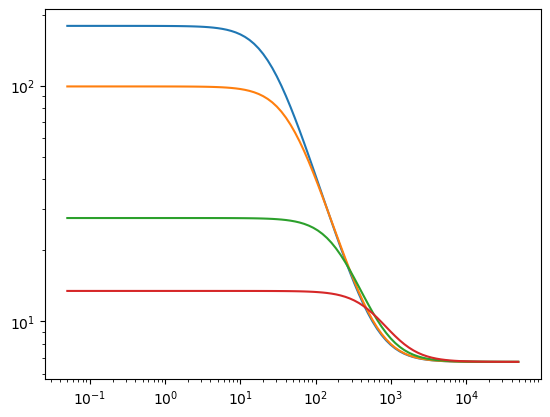

In [11]:
# fi_arr = np.logspace(0, 4.69, 50, endpoint=True, base=10.0)
# Z1 = interface(fi=fi_arr, Rs=3.9e3, Rf=100e3, Cdl=0.068e-6, alpha=580)
# Z2 = interface(fi=fi_arr, Rs=3.9e3, Rf=100e3, Cdl=0.15e-6, alpha=580)
# Z3 = interface(fi=fi_arr, Rs=3.9e3, Rf=100e3, Cdl=0.33e-6, alpha=580)
# Z4 = interface(fi=fi_arr, Rs=3.9e3, Rf=100e3, Cdl=0.56e-6, alpha=580)

Z1 = interface(fi=fi_arr, Rs=3.9e3, Rf=100e3, Cdl=0.068e-6, alpha=580)
Z2 = interface(fi=fi_arr, Rs=3.9e3, Rf=53.6e3, Cdl=0.068e-6, alpha=580)
Z3 = interface(fi=fi_arr, Rs=3.9e3, Rf=12e3, Cdl=0.068e-6, alpha=580)
Z4 = interface(fi=fi_arr, Rs=3.9e3, Rf=3.9e3, Cdl=0.068e-6, alpha=580)


plt.figure()
plt.loglog(fi_arr, np.abs(Z1))
plt.loglog(fi_arr, np.abs(Z2))
plt.loglog(fi_arr, np.abs(Z3))
plt.loglog(fi_arr, np.abs(Z4))
plt.show()

In [12]:
a = np.array(list(EIS_obj.impedance_dict.values()))

0.9954829705952403
0.8012460982489109


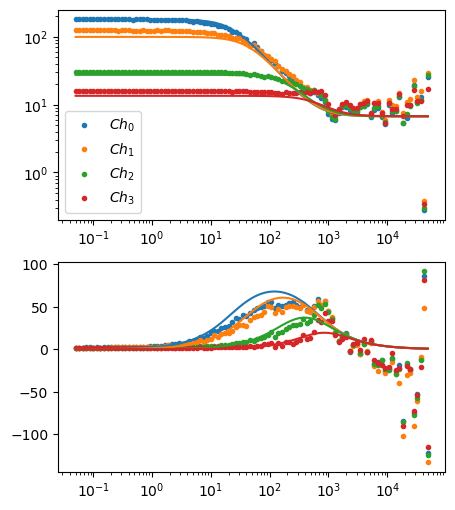

In [13]:
# plt.plot(fi_arr, 20*np.log10(np.abs(a[:,:3])), '-*')
scale=600
s1 = np.abs(Z1[0]/a[0,1])
s2 = np.abs(Z2[0]/a[0,2])
s3 = np.abs(Z3[0]/a[0,3])
s4 = np.abs(Z4[0]/a[0,4])
print(s1)
print(s2)

deg =True
plt.figure(figsize=(5,6))
plt.subplot(2,1,1)
plt.loglog(fi_arr, np.abs(a[:,1:]), '.')
plt.loglog(fi_arr, np.abs(Z1), 'C0-')
plt.loglog(fi_arr, np.abs(Z2), 'C1-')
plt.loglog(fi_arr, np.abs(Z3), 'C2-')
plt.loglog(fi_arr, np.abs(Z4), 'C3-')
# plt.semilogx(fi_arr, np.abs(a[:,1:]), '-*')
# plt.legend(np.arange(a.shape[0]))
plt.legend(['$Ch_0$', '$Ch_1$', '$Ch_2$', '$Ch_3$'])

plt.subplot(2,1,2)
plt.semilogx(fi_arr, -np.angle(a[:,1:], deg=deg), '.')
plt.semilogx(fi_arr, -np.angle(Z1, deg=deg), 'C0-')
plt.semilogx(fi_arr, -np.angle(Z2, deg=deg), 'C1-')
plt.semilogx(fi_arr, -np.angle(Z3, deg=deg), 'C2-')
plt.semilogx(fi_arr, -np.angle(Z4, deg=deg), 'C3-')
# plt.semilogx(fi_arr, np.abs(a[:,1:]), '-*')
# plt.legend(np.arange(a.shape[0]))
plt.show()




/home/akwasi/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


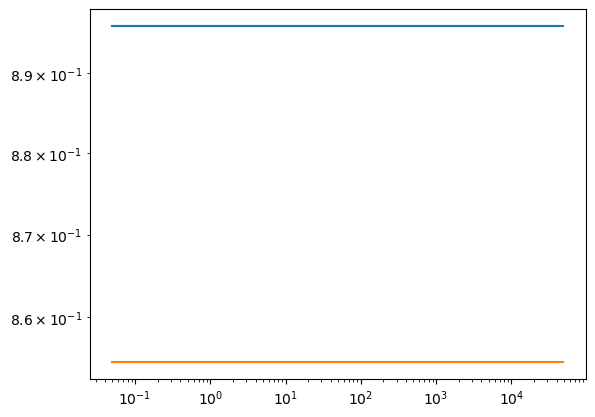

In [14]:
#Calibration curves
b1 = Z1/a[:,1]
b2 = Z2/a[:,2]

# plt.loglog(fi_arr, b1)
# plt.loglog(fi_arr, b2)

plt.loglog(fi_arr, np.mean(b1)*np.ones_like(fi_arr))
plt.loglog(fi_arr, np.mean(b2)*np.ones_like(fi_arr))

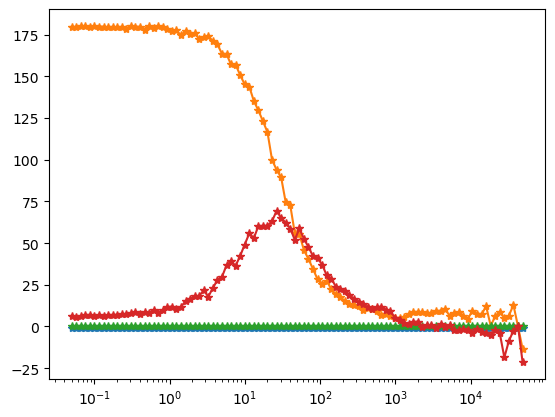

In [15]:
plt.figure()
plt.semilogx(fi_arr, a.real[:,:2], '-*')
plt.semilogx(fi_arr, -a.imag[:,:2], '-*')
plt.show()

In [16]:
1/(2*np.pi*(100e3)*(0.068e-6))

23.40513868998461

In [17]:
from impedance.models.circuits import CustomCircuit

circuit = 'R0-p(R1,C1)'
# initial_guess = [2.7e3, 1.5e3, 1e-8, 2.7e3, 1e-6]
# initial_guess = [-50e-1, -5e-1, 1e-2]
initial_guess = np.array([3.9e3, 100e3, 0.068e-6])

# bounds_list = (initial_guess*0.0001, initial_guess*4)

circuit = CustomCircuit(circuit, initial_guess=initial_guess, )
circuit.fit(fi_arr, a[:,2])
Z_fit = circuit.predict(fi_arr)
Z_fit = circuit.predict(fi_arr)
circuit.parameters_

array([1.01744118e+01, 1.09725189e+02, 3.32308595e-05])

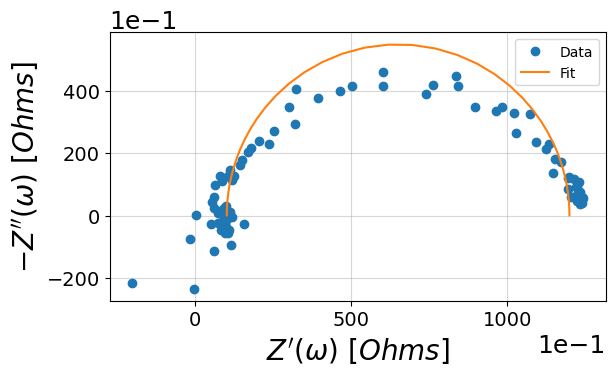

In [18]:
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist

fig, ax = plt.subplots()
plot_nyquist(a[:,2], fmt='o', scale=10, ax=ax)
plot_nyquist(Z_fit, fmt='-', scale=10, ax=ax)


plt.legend(['Data', 'Fit'])
plt.show()

In [19]:
a[:,1]

array([ 1.79836472e+02 -6.40126139j,  1.79635207e+02 -5.88371598j,
        1.80067378e+02 -6.02093088j,  1.80043553e+02 -6.55698528j,
        1.79490840e+02 -6.65455883j,  1.80181375e+02 -6.10744845j,
        1.79919234e+02 -6.80964073j,  1.79827575e+02 -6.39327437j,
        1.79529487e+02 -6.73027269j,  1.79341912e+02 -6.75624112j,
        1.79581313e+02 -7.07024281j,  1.79596093e+02 -7.20660908j,
        1.78711583e+02 -7.51414342j,  1.80151180e+02 -8.08175715j,
        1.79924208e+02 -8.38621208j,  1.79655020e+02 -7.71146538j,
        1.78132956e+02 -8.44364844j,  1.80310990e+02 -7.91201009j,
        1.79203032e+02 -9.89989937j,  1.80180966e+02 -8.22946463j,
        1.79890772e+02 -9.81846948j,  1.78184299e+02-11.55121456j,
        1.76994756e+02-11.88798879j,  1.77768988e+02-10.71776574j,
        1.74544336e+02-11.68684571j,  1.77474225e+02-15.16958709j,
        1.75241041e+02-16.47846218j,  1.75931231e+02-18.07087783j,
        1.72564780e+02-18.27426663j,  1.73812526e+02-21.768435

/home/akwasi/anaconda3/lib/python3.9/site-packages/impedance/visualization.py:109: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_mag.plot(f, np.abs(Z), fmt, **kwargs)
/home/akwasi/anaconda3/lib/python3.9/site-packages/impedance/visualization.py:109: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax_mag.plot(f, np.abs(Z), fmt, **kwargs)
/home/akwasi/anaconda3/lib/python3.9/site-packages/impedance/visualization.py:110: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_phs.plot(f, -np.angle(Z, deg=True), fmt, **kwargs)
/home/akwasi/anaconda3/lib/python3.9/site-packages/impedance/visualization.py:110: UserWarning: marker is redun

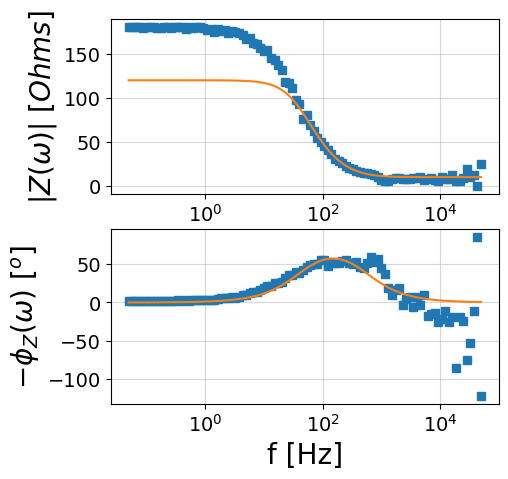

In [20]:
circuit.plot(f_data=fi_arr, Z_data=a[:,1], kind='bode')
plt.show()

